In [1]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Vertex AI Model Garden - Get started with Llama 3.2 models

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/community/model_garden/model_garden_openai_api_llama3_2.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo"><br> Open in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fvertex-ai-samples%2Fmain%2Fnotebooks%2Fcommunity%2Fmodel_garden%2Fmodel_garden_openai_api_llama3_2.ipynb"">
      <img width="32px" src="https://cloud.google.com/ml-engine/images/colab-enterprise-logo-32px.png" alt="Google Cloud Colab Enterprise logo"><br> Open in Colab Enterprise
    </a>
  </td>    
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/community/model_garden/model_garden_openai_api_llama3_2.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo"><br> Open in Workbench
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/community/model_garden/model_garden_openai_api_llama3_2.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
</table>

## Overview

This notebook demonstrates how to get started with using the OpenAI library and demonstrates how to leverage multimodal capabilities of Llama 3.2 models as Model-as-service (MaaS).

### Objective

- Configure OpenAI SDK for the Llama 3.2 Completions API
- Chat with Llama 3.2 models with different prompts and model parameters
- Build and use Llama 3.2 GenAI powered application for Car Damage Assessment.

### Costs

This tutorial uses billable components of Google Cloud:

* Vertex AI
* Cloud Storage

Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing), [Cloud Storage pricing](https://cloud.google.com/storage/pricing), and use the [Pricing Calculator](https://cloud.google.com/products/calculator/) to generate a cost estimate based on your projected usage.

## Get started

### Install Vertex AI SDK for Python and other required packages


In [2]:
! pip3 install --upgrade --quiet google-cloud-aiplatform openai gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.5/389.5 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.1/320.1 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 108.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 10.5 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Restart runtime (Colab only)

To use the newly installed packages, you must restart the runtime on Google Colab.

In [4]:
import sys

if "google.colab" in sys.modules:

    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Wait until it's finished before continuing to the next step. ⚠️</b>
</div>


### Authenticate your notebook environment (Colab only)

Authenticate your environment on Google Colab.


In [5]:
import sys

if "google.colab" in sys.modules:

    from google.colab import auth

    auth.authenticate_user()

### Set Google Cloud project information

To get started using Vertex AI, you must have an existing Google Cloud project and [enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com). Learn more about [setting up a project and a development environment](https://cloud.google.com/vertex-ai/docs/start/cloud-environment).

In [1]:
PROJECT_ID = "upheld-quanta-442214-i7"  # @param {type:"string"}

# Only `us-central1` is supported region for Llama 3.2 models using Model-as-a-Service (MaaS).
LOCATION = "us-central1"

### Create a Cloud Storage bucket

Create a storage bucket to store tutorial artifacts.

In [2]:
BUCKET_NAME = "<your-bucket-name>"  # @param {type:"string"}

BUCKET_URI = f"gs://{BUCKET_NAME}"

**If your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [3]:
! gsutil mb -l {LOCATION} -p {PROJECT_ID} {BUCKET_URI}

/bin/bash: -c: line 1: syntax error near unexpected token `newline'
/bin/bash: -c: line 1: ` gsutil mb -l us-central1 -p upheld-quanta-442214-i7 gs://<your-bucket-name>'


### Initialize Vertex AI SDK for Python

In [4]:
import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION, staging_bucket=BUCKET_URI)

### Import libraries

Import libraries to use in this tutorial.

In [5]:
import json
import re
import uuid
from io import BytesIO

import gradio as gr
import matplotlib.pyplot as plt
# Chat completions API
import openai
from google.auth import default, transport
from google.cloud import storage
from PIL import Image

### Helpers functions

In [6]:
def visualize_image_from_bucket(bucket_name: str, blob_name: str) -> None:
    """Visualizes an image stored in a Google Cloud Storage bucket."""
    try:
        # Create a client for interacting with Google Cloud Storage
        storage_client = storage.Client()

        # Get a reference to the bucket and blob
        bucket = storage_client.bucket(bucket_name)
        blob = bucket.blob(blob_name)

        # Download the image data into memory
        image_data = blob.download_as_bytes()

        # Open the image using PIL
        image = Image.open(BytesIO(image_data))

        # Display the image using matplotlib
        plt.figure(figsize=(10, 10))  # Set the figure size (adjust as needed)
        plt.imshow(image)
        plt.axis("off")  # Turn off axis labels
        plt.show()

    except Exception as e:
        print(f"Error visualizing image: {e}")

### Configure OpenAI SDK for the Llama 3.2 Chat Completions API

To configure the OpenAI SDK for the Llama 3.2 Chat Completions API, you need to request the access token and initialize the client pointing to the Llama 3.2 endpoint.


#### Authentication

You can request an access token from the default credentials for the current environment. Note that the access token lives for [1 hour by default](https://cloud.google.com/docs/authentication/token-types#at-lifetime); after expiration, it must be refreshed.


In [7]:
credentials, _ = default()
auth_request = transport.requests.Request()
credentials.refresh(auth_request)

Then configure the OpenAI SDK to point to the Llama 3.2 Chat Completions API endpoint.

Notice, only `us-central1` is supported region for Llama 3.2 models using Model-as-a-Service (MaaS).

In [8]:
MODEL_LOCATION = "us-central1"
MAAS_ENDPOINT = f"{MODEL_LOCATION}-aiplatform.googleapis.com"

client = openai.OpenAI(
    base_url=f"https://{MAAS_ENDPOINT}/v1beta1/projects/{PROJECT_ID}/locations/{LOCATION}/endpoints/openapi",
    api_key=credentials.token,
)

#### Llama 3.2 models

You can experiment with various supported Llama 3.2 models.

This tutorial use Llama 3.2 90B Vision Instruct using Model-as-a-Service (MaaS). Using Model-as-a-Service (MaaS), you can access Llama 3.2 models in just a few clicks without any setup or infrastructure hassles.

You can also access Llama models for self-service in Vertex AI Model Garden, allowing you to choose your preferred infrastructure. [Check out Llama 3.2 model card](https://console.cloud.google.com/vertex-ai/publishers/meta/model-garden/llama3-2?_ga=2.31261500.2048242469.1721714335-1107467625.1721655511) to learn how to deploy a Llama 3.2 models on Vertex AI.

In [9]:
MODEL_ID = "meta/llama-3.2-90b-vision-instruct-maas"  # @param {type:"string"} ["meta/llama-3.2-90b-vision-instruct-maas"]

### Chat with Llama 3.2

Use the Chat Completions API to send a multi-model request to the Llama 3.2 model.

#### Hello, Llama 3.2

In [14]:
max_tokens = 4096

response = client.chat.completions.create(
    model=MODEL_ID,
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "image_url": {
                        "url": "gs://github-repo/img/gemini/intro/landmark1.jpg"
                    },
                    "type": "image_url",
                },
                {"text": "What’s in this image?", "type": "text"},
            ],
        },
        {"role": "assistant", "content": "In this image, you have:"},
    ],
    max_tokens=max_tokens,
)

You get the response as shown below.

In [15]:
print(response.choices[0].message.content)

The Houses of Parliament, the Westminster Bridge, and the Elizabeth Tower, commonly known as Big Ben.


You use the helper function to visualize the image.

In [ ]:
visualize_image_from_bucket("github-repo", "img/gemini/intro/landmark1.jpg")

#### Ask Llama 3.2 using different model configuration

Use the following parameters to generate different answers:

*   `temperature` to control the randomness of the response
*   `top_p` to control the quality of the response
*   `stream` to stream the response back or not


In [16]:
temperature = 1.0  # @param {type:"number"}
top_p = 1.0  # @param {type:"number"}
stream = True  # @param {type:"boolean"}

Get the answer.

In [17]:
response = client.chat.completions.create(
    model=MODEL_ID,
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "image_url": {
                        "url": "gs://github-repo/img/gemini/intro/landmark2.jpg"
                    },
                    "type": "image_url",
                },
                {"text": "What’s in this image?", "type": "text"},
            ],
        },
        {"role": "assistant", "content": "In this image, you have:"},
    ],
    temperature=temperature,
    max_tokens=max_tokens,
    top_p=top_p,
    stream=stream,
)

Depending if `stream` parameter is enabled or not, you can print the response entirely or chunk by chunk.

In [18]:
if stream:
    for chunk in response:
        print(chunk.choices[0].delta.content, end="")
else:
    print(response.choices[0].message.content)

Aerial view of the Eiffel Tower in Paris, France.

And again, let's check if the answer is correct.

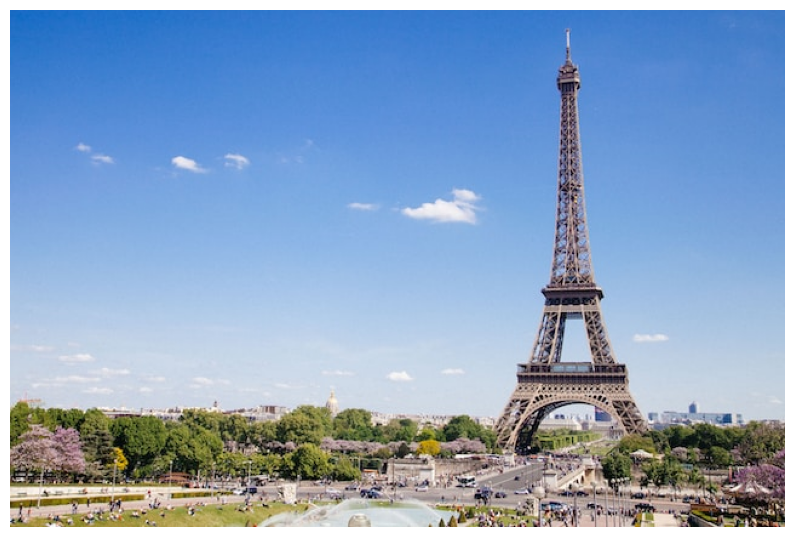

In [19]:
visualize_image_from_bucket("github-repo", "img/gemini/intro/landmark2.jpg")

#### Use Llama 3.2 with different multimodal tasks

In this section, you will use Llama 3.2 to perform different multimodal tasks including image captioning and Visual Question Answering (VQA).

For each task, you'll define a different prompt and submit a request to the model as you did before.

In [ ]:
visualize_image_from_bucket("github-repo", "img/gemini/intro/landmark3.jpg")

##### Image captioning

In [ ]:
prompt = "Imagine you're telling a friend about this photo. What would you say?"

In [ ]:
response = client.chat.completions.create(
    model=MODEL_ID,
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "image_url": {
                        "url": "gs://github-repo/img/gemini/intro/landmark3.jpg"
                    },
                    "type": "image_url",
                },
                {"text": prompt, "type": "text"},
            ],
        },
    ],
    max_tokens=max_tokens,
)

In [ ]:
print(response.choices[0].message.content)

##### Visual Question Answering (VQA)

In [ ]:
prompt = """
Analyze this image and answer the following questions:
- What is the primary color in the image?
- What is the overall mood or atmosphere conveyed in the scene?
- Based on the visual clues, who might have taken the picture?"
"""

In [ ]:
response = client.chat.completions.create(
    model=MODEL_ID,
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "image_url": {
                        "url": "gs://github-repo/img/gemini/intro/landmark3.jpg"
                    },
                    "type": "image_url",
                },
                {"text": prompt, "type": "text"},
            ],
        },
    ],
    max_tokens=max_tokens,
)

In [ ]:
print(response.choices[0].message.content)

### Build with Llama 3.2 : Car Damage Assessment app using Gradio

In this section, you use Llama 3.2 to build a simple GenAI powered application for Car Damage Assessment.

In this scenario, the app has to cover the following tasks:

*   Classify the type of damage
*   Estimate the damage severity
*   Estimate the damage cost


#### Define the UI functions

In [ ]:
def upload_image_to_bucket(image_path: str) -> str:
    """Uploads an image to a Google Cloud Storage bucket."""
    try:
        # Create a client for interacting with Google Cloud Storage
        storage_client = storage.Client()

        # Get a reference to the bucket
        bucket = storage_client.bucket(BUCKET_NAME)

        # Generate a unique blob name based on the file extension
        file_extension = image_path.split(".")[-1].lower()
        if file_extension in ["jpg", "jpeg"]:
            blob_name = f"car_damage_{uuid.uuid4()}.jpg"
        else:
            blob_name = f"car_damage_{uuid.uuid4()}.png"

        # Get a reference to the blob and upload the image
        blob = bucket.blob(blob_name)
        blob.upload_from_filename(image_path)

        # Construct the URI of the uploaded image
        image_uri = f"gs://{BUCKET_NAME}/{blob_name}"
        return image_uri

    except Exception as e:
        print(f"Error uploading image: {e}")


def parse_json_from_markdown(markdown_text: str) -> dict | None:
    """Extracts and parses JSON content embedded within Markdown text."""
    json_pattern = r"```json\n(.*?)\n```"
    match = re.search(json_pattern, markdown_text, re.DOTALL)

    if match:
        json_content = match.group(1)
        try:
            parsed_data = json.loads(json_content)
            return parsed_data
        except json.JSONDecodeError as e:
            print(f"Error: Invalid JSON content found. {e}")
            return None
    else:
        return None


def process_image(image_uri):
    """Processes a car damage image using a multimodal LLM."""

    # Construct the prompt
    prompt = """
    Analyze the provided image of a car and provide the following information:

    1. Damage Type: Identify the primary type of damage visible in the image (e.g., dent, scratch, cracked windshield, etc.).
    2. Severity: Estimate the severity of the damage on a scale of 1 to 5, where 1 is minor and 5 is severe.
    3. Estimated Repair Cost: Provide an approximate range for the repair cost in USD.

    Return the results in JSON format with damagetype, severity, and cost fields.
    """

    # Call Llama model
    credentials, _ = default()
    auth_request = transport.requests.Request()
    credentials.refresh(auth_request)

    client = openai.OpenAI(
        base_url=f"https://{MAAS_ENDPOINT}/v1beta1/projects/{PROJECT_ID}/locations/{LOCATION}/endpoints/openapi",
        api_key=credentials.token,
    )
    response = client.chat.completions.create(
        model=MODEL_ID,
        messages=[
            {
                "role": "user",
                "content": [
                    {"image_url": {"url": image_uri}, "type": "image_url"},
                    {"text": prompt, "type": "text"},
                ],
            },
        ],
        max_tokens=max_tokens,
    )

    # Parse the response
    response = response.choices[0].message.content
    output = parse_json_from_markdown(response)

    output = {"damagetype": "scratch", "severity": 5, "cost": 1000}
    return output["damagetype"], output["severity"], output["cost"]


def demo_fn(image_path):
    """
    Processes a car damage image using a multimodal LLM.
    """

    # Upload the image
    image_uri = upload_image_to_bucket(image_path)

    # Process the image
    damagetype, severity, cost = process_image(image_uri)

    return damagetype, severity, cost

#### Run the application

In [ ]:
demo = gr.Interface(
    fn=demo_fn,
    inputs=gr.Image(type="filepath"),
    outputs=[
        gr.Textbox(label="Damage Type"),
        gr.Slider(label="Severity", minimum=1, maximum=10, step=1),
        gr.Number(label="Cost"),
    ],
    title="Car Damage Assessment",
)

demo.launch(debug=True)

In [ ]:
demo.close()

## Cleaning up

Clean up resources created in this notebook.

To delete to the search engine in Vertex AI, check out the following [documentation](https://cloud.google.com/generative-ai-app-builder/docs/delete-engine).

In [ ]:
delete_bucket = False  # @param {type:"boolean"}

if delete_bucket:
    ! gsutil -m rm -r $BUCKET_NAME